# Seccion preparatoria
Instalamos los complementos, cargamos los dos Datasets y exportamos las librerias necesarias.

DataSets necesarios
https://drive.google.com/drive/folders/1MYhKkvSrkhMqUpBa7ldycwBl9zBBK4bb?usp=sharing

Importación de librerias necesarias para la ejecucción



¿Qué es PMDArima?
Proveniente de "pyramid - arima" es una libreria diseñada para el analisis de series temporales de python.

**Entre sus funciones a aplicar en el proyecto están:**  
• Colección de pruebas estadísticas  
• Pipelines de Scikit-learn para estimadores   

La cual la convierte en un módulo potente y hábil para nuestro proyecto.

In [ ]:
!pip install pandas==1.2.0
!pip install --upgrade xlrd
!pip install pmdarima > /dev/null #linea para importar nuestro arima


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Explicación de los datos en general:  
  
fecha: cada fecha de los artículos vendidos  
date_block_num: este número se asigna a cada mes  
shop_id: número único de cada tienda  
item_id - número único de cada artículo  
item_price - precio de cada artículo  
item_cnt_day - número de artículos vendidos en un día en particular

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import datetime #importacion de libreria datetime
import pmdarima as pm # importacion de libreria pmd arima
from pmdarima.arima import auto_arima # importacion de la funcion auto_arima


filenameuno = "sales_train.csv"
datostrain = pd.read_csv(filenameuno,header=0)
#filenamedos = "test.csv"
#datostest = pd.read_csv(filenamedos, header=0)
#datostrain = pd.read_csv(filenameuno, error_bad_lines=False, header=0)     #linea alterna en caso de algún error de carga de datos, error 
#datostest = pd.read_csv(filenamedos, error_bad_lines=False, header=0)     #linea alterna en caso de algún error de carga de datos, error 

ModuleNotFoundError: ignored

Para este ejemplo en concreto se nos ha solicitado elegir una tienda de todas las implementadas en nuestro conjunto de datos, en este caso hemos decidido usar la 45, sin embargo esta pudo haber sido cualquiera

In [ ]:
datostrain = datostrain.loc[datostrain['shop_id'] == 45] 
#datostest = datostest.loc[datostest['shop_id'] == 45] 
datostrain

NameError: ignored

Aqui formatearemos dos columnas, en este caso a **date** le daremos un formato de dia, mes y año siendo datetime, mientras que a **month_year** le daremos como mes y año

In [ ]:
datostrain['date']=datostrain['date'].apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
datostrain['month_year'] = datostrain['date'].dt.to_period('M')
datostrain.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
month_year             period[M]
dtype: object

In [ ]:
datostrain

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month_year
112221,2013-01-18,0,45,3718,349.0,2.0,2013-01
112222,2013-01-04,0,45,3704,1499.0,1.0,2013-01
112223,2013-01-26,0,45,3702,598.5,1.0,2013-01
112224,2013-01-12,0,45,3702,599.0,1.0,2013-01
112225,2013-01-04,0,45,3702,598.5,1.0,2013-01
...,...,...,...,...,...,...,...
2883113,2015-10-24,33,45,5821,1099.0,1.0,2015-10
2883114,2015-10-11,33,45,5822,1149.0,1.0,2015-10
2883115,2015-10-22,33,45,5822,1149.0,1.0,2015-10
2883116,2015-10-23,33,45,5822,1149.0,1.0,2015-10


Sumarizamos todo el month_year x item_cnt_dat para luego resetear con el valor nuevo  
Es decir un reemplazo, en vez de tratar de articulo vendido por día, será articulo vendido por mes

In [ ]:
grouped_df = datostrain.groupby(['month_year'])['month_year','item_cnt_day'].agg({'item_cnt_day':'sum'})
grouped_df = grouped_df.reset_index()
#grouped_df.set_index(['month_year'], inplace=True)
grouped_df.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)
grouped_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,item_cnt_month
month_year,
2013-01,1634.0
2013-02,1530.0
2013-03,1883.0
2013-04,1253.0
2013-05,1333.0
2013-06,1785.0
2013-07,1507.0
2013-08,1649.0
2013-09,1725.0


#CREACION DE MODELO


A continuación, ¿cuáles son los términos 'p' y 'q'? 'p' es el orden del término 'Auto Regresivo' (AR). Se refiere al número de retrasos de Y que se utilizarán como predictores. Y 'q' es el orden del término 'promedio móvil' (MA). Se refiere a la cantidad de errores de pronóstico retrasados ​​que deben incluirse en el modelo ARIMA.

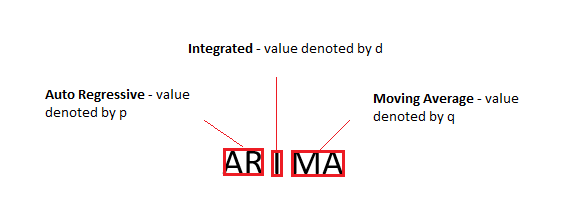





Aqui haremos uso de la poderosa función autoarima  
Tenemos los siguientes paso de parámetros:

y=recibe nuestros datos

m = El período de diferenciación estacional, m se refiere al número de períodos en cada estación. Por ejemplo, m es 4 para datos trimestrales, 12 para datos mensuales o 1 para datos anuales (no estacionales). 

In [ ]:
model = auto_arima(y=grouped_df,m=12)

Creación de la predicción

In [ ]:
prediction, confint = model.predict(n_periods=12, return_conf_int=True)
confint_df = pd.DataFrame(confint)
prediction

array([ 828.13636364, 1128.13636364,  557.13636364,  373.13636364,
        317.13636364,  439.13636364,  339.13636364,  199.13636364,
        252.13636364,  287.13636364,  231.13636364,  279.13636364])

Indice de predicción

In [ ]:
period_index = pd.period_range(
    start = grouped_df.index[-1],
    periods = 12,
    freq='M'
)
predicted_df = pd.DataFrame({'value':prediction}, index=period_index)
predicted_df

,value
2015-10,828.136364
2015-11,1128.136364
2015-12,557.136364
2016-01,373.136364
2016-02,317.136364
2016-03,439.136364
2016-04,339.136364
2016-05,199.136364
2016-06,252.136364
2016-07,287.136364


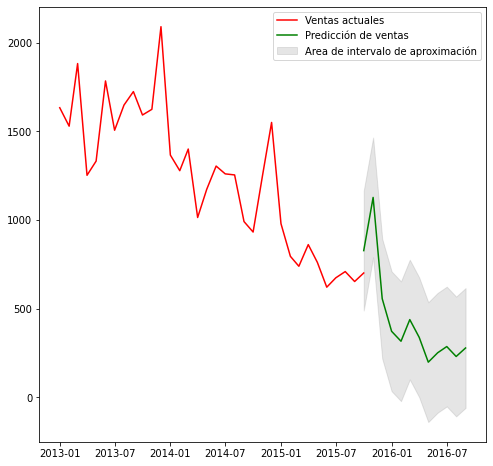

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(grouped_df.to_timestamp(),color='red', label='Ventas actuales')
plt.plot(predicted_df.to_timestamp(), color='green', label='Predicción de ventas')
plt.fill_between(period_index.to_timestamp(), confint_df[0], confint_df[1],color='grey',alpha=.2, label='Area de intervalo de aproximación')
plt.legend()
plt.show()

In [ ]:
print(f'Ventas ultimo mes: {round((predicted_df.values[0][0]),3)}')
print(f'Ventas siguiente mes: {round(prediction[1],3)}')

Ventas ultimo mes: 828.136
Ventas siguiente mes: 1128.136


In [ ]:
print(model.summary())

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   34
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -144.495
Date:                  Wed, 06 Jul 2022   AIC                            292.989
Time:                          01:01:09   BIC                            295.171
Sample:                               0   HQIC                           293.503
                                   - 34                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -422.8636     37.155    -11.381      0.000    -495.687    -350.041
sigma2      2.967e+04   1.36e+04      2.182      0.029    3023.854    5.63e+04
Ljung-Box (L1) (Q):                 